In [8]:
pip install tensorflow_decision_forests

In [60]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.1 MB/s eta 0:00:00


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier


In [11]:
df = pd.read_csv("/content/datasets/car_eval.csv")

In [12]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [13]:
df.shape

(1727, 7)

<Axes: ylabel='count'>

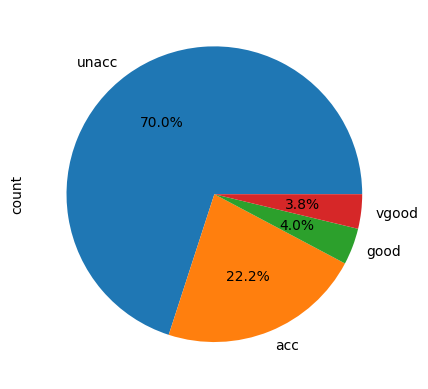

In [14]:
df['class'].value_counts().plot(kind ='pie',autopct = '%1.1f%%')

In [54]:
df['buying'] = df['buying'].map({'low':0, 'med':1, 'high':2, 'vhigh':3})
df['maint'] = df['maint'].map({'low':0, 'med':1, 'high':2, 'vhigh':3})
df['doors'] = df['doors'].map({'2':0, '3':1, '4':2, '5more':3})
df['persons'] = df['persons'].map({'2':0, '4':1, 'more':2})
df['lug_boot'] = df['lug_boot'].map({'small':0, 'med':1, 'big':2})
df['safety'] = df['safety'].map({'low':0, 'med':1, 'high':2})
df['class'] = df['class'].map({'unacc':0, 'acc':1, 'good':2, 'vgood':3})


In [15]:
dft=df.copy()


In [16]:
# label_encoders = {}
# for column in dft.select_dtypes(include=['object']).columns:
#     le = LabelEncoder()
#     df[column] = le.fit_transform(df[column])
#     label_encoders[column] = le

In [17]:
# print(label_encoders)

In [18]:
col_name = ['buying','maint' ,'doors','persons','lug_boot','safety','class']
dft.columns = col_name
col_name

['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

In [19]:
dft['buying'] = dft['buying'].map({'low':0, 'med':1, 'high':2, 'vhigh':3})
dft['maint'] = dft['maint'].map({'low':0, 'med':1, 'high':2, 'vhigh':3})
dft['doors'] = dft['doors'].map({'2':0, '3':1, '4':2, '5more':3})
dft['persons'] = dft['persons'].map({'2':0, '4':1, 'more':2})
dft['lug_boot'] = dft['lug_boot'].map({'small':0, 'med':1, 'big':2})
dft['safety'] = dft['safety'].map({'low':0, 'med':1, 'high':2})
dft['class'] = dft['class'].map({'unacc':0, 'acc':1, 'good':2, 'vgood':3})


In [20]:
dft.tail()


,buying,maint,doors,persons,lug_boot,safety,class
1722,0,0,3,2,1,1,2
1723,0,0,3,2,1,2,3
1724,0,0,3,2,2,0,0
1725,0,0,3,2,2,1,2
1726,0,0,3,2,2,2,3


In [21]:
for col in col_name:
  print(dft[col].value_counts())

buying
2    432
1    432
0    432
3    431
Name: count, dtype: int64
maint
2    432
1    432
0    432
3    431
Name: count, dtype: int64
doors
1    432
2    432
3    432
0    431
Name: count, dtype: int64
persons
1    576
2    576
0    575
Name: count, dtype: int64
lug_boot
1    576
2    576
0    575
Name: count, dtype: int64
safety
1    576
2    576
0    575
Name: count, dtype: int64
class
0    1209
1     384
2      69
3      65
Name: count, dtype: int64


In [22]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dft)
print("{} data utk training, {} data utk testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

1379 data utk training, 348 data utk testing.


In [23]:
smote = SMOTE(random_state=42)
X_train = train_ds_pd.drop('class', axis=1)
y_train = train_ds_pd['class']
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [24]:
columns = X_train.columns
train_ds_pd_resampled = pd.DataFrame(X_train_resampled, columns=columns)
train_ds_pd_resampled['class'] = y_train_resampled

In [25]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd_resampled, label='class')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='class')

print(f"Training dataset shape: {train_ds_pd_resampled.shape}")
print(f"Testing dataset shape: {test_ds_pd.shape}")

Training dataset shape: (3840, 7)
Testing dataset shape: (348, 7)


In [26]:
for col in col_name:
  print(train_ds_pd_resampled[col].value_counts())

buying
0    1838
1    1050
2     527
3     425
Name: count, dtype: int64
maint
0    1568
1    1132
2     698
3     442
Name: count, dtype: int64
doors
2    1152
0     977
1     898
3     813
Name: count, dtype: int64
persons
1    1932
2    1457
0     451
Name: count, dtype: int64
lug_boot
1    1491
2    1387
0     962
Name: count, dtype: int64
safety
2    2016
1    1366
0     458
Name: count, dtype: int64
class
0    960
1    960
3    960
2    960
Name: count, dtype: int64


In [27]:
model = tfdf.keras.GradientBoostedTreesModel(num_trees=500,
                                             growing_strategy="BEST_FIRST_GLOBAL",
                                             max_depth=8,
                                             split_axis="SPARSE_OBLIQUE",
                                             categorical_algorithm="RANDOM",)

training = model.fit(train_ds)

Use /tmp/tmpqx1snzf4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:13.319332. Found 3840 examples.
Training model...
Model trained in 0:00:15.399184
Compiling model...
Model compiled.


In [28]:
model.compile(metrics=['accuracy'])

evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.6f}")

1/1 [==============================] - 6s 6s/step - loss: 0.0000e+00 - accuracy: 0.9770

loss: 0.000000
accuracy: 0.977012


In [29]:
inspector = model.make_inspector()

In [30]:
print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 228
Objective: Classification(label=__LABEL, class=None, num_classes=4)
Input features: ["buying" (1; #1), "doors" (1; #2), "lug_boot" (1; #3), "maint" (1; #4), "persons" (1; #5), "safety" (1; #6)]


In [31]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 NUM_NODES
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE


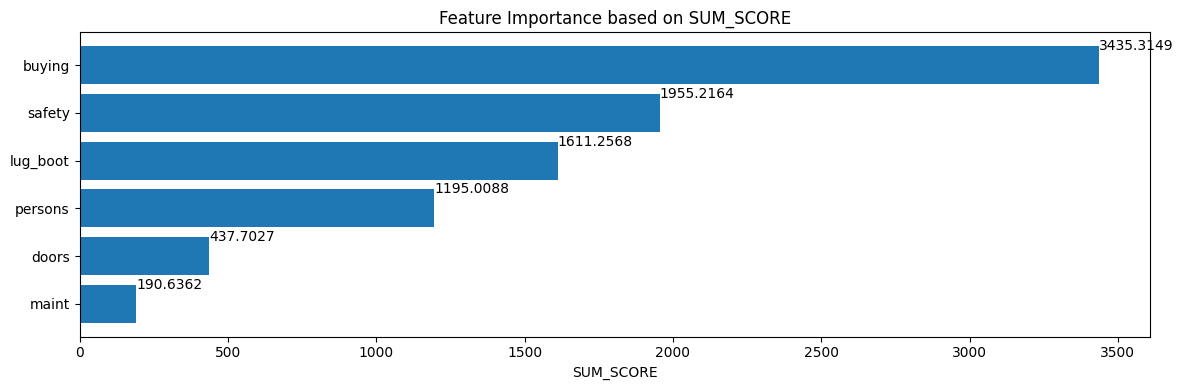

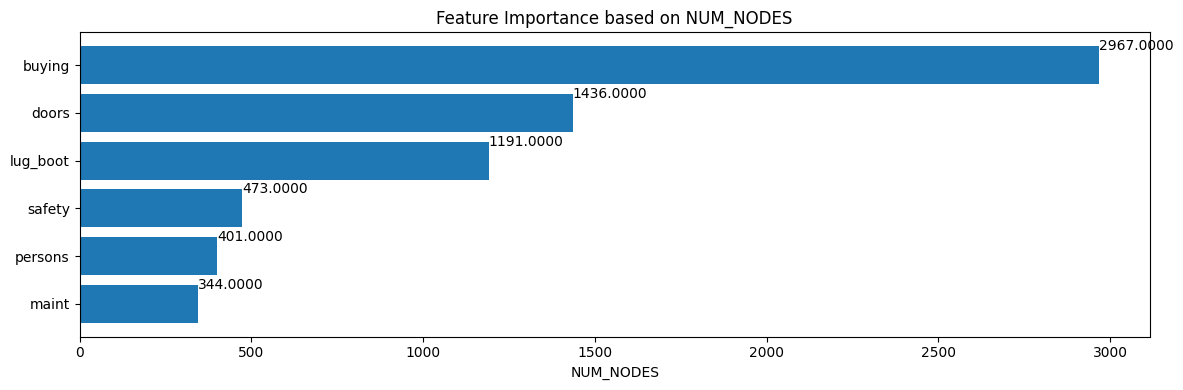

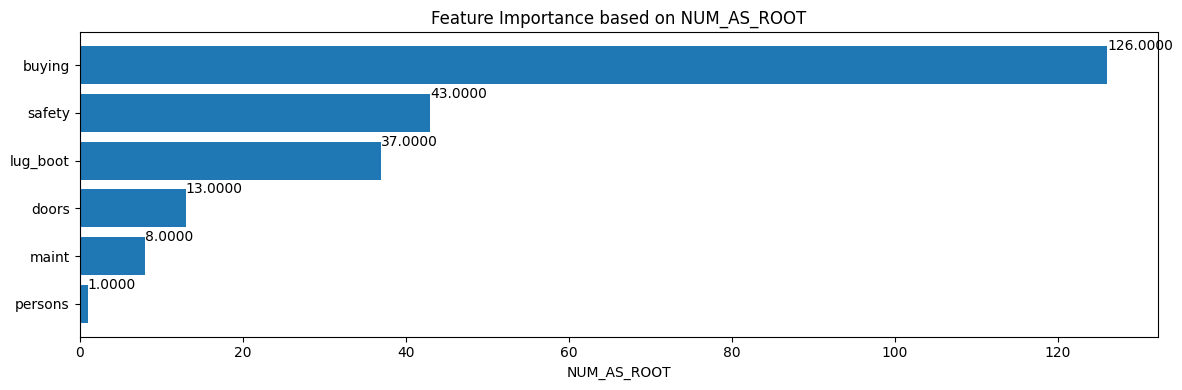

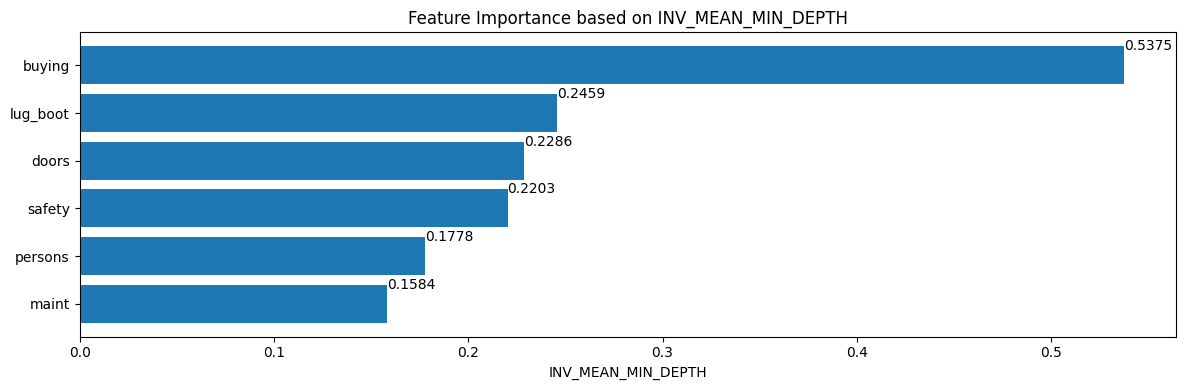

In [37]:
importance_metrics = ["SUM_SCORE", "NUM_NODES", "NUM_AS_ROOT", "INV_MEAN_MIN_DEPTH"]

for variable_importance_metric in importance_metrics:
    plt.figure(figsize=(12, 4))
    variable_importances = inspector.variable_importances()[variable_importance_metric]

    feature_names = [vi[0].name for vi in variable_importances]
    feature_importances = [vi[1] for vi in variable_importances]
    feature_ranks = range(len(feature_names))

    bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
    plt.yticks(feature_ranks, feature_names)
    plt.gca().invert_yaxis()

    for importance, patch in zip(feature_importances, bar.patches):
        plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="center")

    plt.xlabel(variable_importance_metric)
    plt.title(f"Feature Importance based on {variable_importance_metric}")
    plt.tight_layout()
    plt.show()


'persons' dan 'maint' di drop

In [38]:
dft1= train_ds_pd_resampled.copy()

In [39]:
dfe1= test_ds_pd.copy()

In [40]:
for col in col_name:
  print(dft1[col].value_counts())

buying
0    1838
1    1050
2     527
3     425
Name: count, dtype: int64
maint
0    1568
1    1132
2     698
3     442
Name: count, dtype: int64
doors
2    1152
0     977
1     898
3     813
Name: count, dtype: int64
persons
1    1932
2    1457
0     451
Name: count, dtype: int64
lug_boot
1    1491
2    1387
0     962
Name: count, dtype: int64
safety
2    2016
1    1366
0     458
Name: count, dtype: int64
class
0    960
1    960
3    960
2    960
Name: count, dtype: int64


In [41]:
dropped_features = ['maint', 'persons']

dft1.drop(columns=dropped_features, inplace=True)
dfe1.drop(columns=dropped_features, inplace=True)

In [42]:
dft1.head()

,buying,doors,lug_boot,safety,class
0,3,0,0,1,0
1,3,0,1,1,0
2,3,0,2,0,0
3,3,0,2,1,0
4,3,0,2,2,0


In [43]:
train_ds1 = tfdf.keras.pd_dataframe_to_tf_dataset(dft1, label='class')
test_ds1 = tfdf.keras.pd_dataframe_to_tf_dataset(dfe1, label='class')

In [44]:
model = tfdf.keras.GradientBoostedTreesModel(num_trees=500,
                                             growing_strategy="BEST_FIRST_GLOBAL",
                                             max_depth=8,
                                             split_axis="SPARSE_OBLIQUE",
                                             categorical_algorithm="RANDOM",)

training = model.fit(train_ds1)

Use /tmp/tmp9aedof0x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.229212. Found 3840 examples.
Training model...
Model trained in 0:00:09.424977
Compiling model...
Model compiled.


In [45]:
model.compile(metrics=['accuracy'])

evaluation = model.evaluate(test_ds1, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.6f}")

1/1 [==============================] - 0s 307ms/step - loss: 0.0000e+00 - accuracy: 0.5661

loss: 0.000000
accuracy: 0.566092


Karena akurasinya malah turun, jd sebaiknya fiturnya gausah di drop


# Comparison model


In [55]:
dft2= train_ds_pd_resampled.copy()

In [56]:
X = dft2.drop(['class'], axis=1)

y = dft2['class']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [58]:
X_train.shape, X_test.shape

((2572, 6), (1268, 6))

In [59]:
def make_model(model):

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    result = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, average='weighted'),  # or 'micro', 'macro', 'weighted'
        "Recall": recall_score(y_test, preds, average='weighted'),  # or 'micro', 'macro', 'weighted'
        "F1-Score": f1_score(y_test, preds, average='weighted')  # or 'micro', 'macro', 'weighted'
    }

    result = pd.DataFrame(result, index=[0])

    return result

In [62]:
models = {
    "Random Forest": RandomForestClassifier(),
    "CatBoost": CatBoostClassifier(),
    "XGBoost": XGBClassifier(),
    "Extra Tree": ExtraTreesClassifier(),
    "GBT": GradientBoostingClassifier(),
    "Gaussian": GaussianProcessClassifier(),

}

comparison = pd.DataFrame(columns=["model", "Accuracy", "Precision", "Recall", "F1-Score"])

for model_name, model in models.items():
    result = make_model(model)
    result["model"] = model_name
    comparison = pd.concat([comparison, result], ignore_index=True)

Learning rate set to 0.083032
0:	learn: 1.2271714	total: 48.2ms	remaining: 48.1s
1:	learn: 1.1121098	total: 50ms	remaining: 24.9s
2:	learn: 1.0103920	total: 57.4ms	remaining: 19.1s
3:	learn: 0.9265206	total: 59ms	remaining: 14.7s
4:	learn: 0.8560128	total: 60.5ms	remaining: 12s
5:	learn: 0.7988246	total: 62.2ms	remaining: 10.3s
6:	learn: 0.7450790	total: 63.8ms	remaining: 9.05s
7:	learn: 0.6985130	total: 70.4ms	remaining: 8.73s
8:	learn: 0.6613376	total: 72.1ms	remaining: 7.93s
9:	learn: 0.6269447	total: 74.1ms	remaining: 7.33s
10:	learn: 0.5946225	total: 75.8ms	remaining: 6.81s
11:	learn: 0.5647679	total: 77.7ms	remaining: 6.4s
12:	learn: 0.5380846	total: 79.5ms	remaining: 6.04s
13:	learn: 0.5126012	total: 87.2ms	remaining: 6.14s
14:	learn: 0.4899527	total: 88.9ms	remaining: 5.84s
15:	learn: 0.4698062	total: 95.7ms	remaining: 5.89s
16:	learn: 0.4525782	total: 97.3ms	remaining: 5.63s
17:	learn: 0.4346842	total: 98.8ms	remaining: 5.39s
18:	learn: 0.4195695	total: 101ms	remaining: 5.2s
1

In [63]:
comparison


,model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.985804,0.985856,0.985804,0.985800
1,CatBoost,0.987382,0.987443,0.987382,0.987382
2,XGBoost,0.985804,0.985899,0.985804,0.985817
3,Extra Tree,0.986593,0.986634,0.986593,0.986583
4,GBT,0.981073,0.981337,0.981073,0.981113
5,Gaussian,0.970820,0.971484,0.970820,0.970839


In [ ]:
train_ds_pd_resampled.to_csv('../content/datasets/eval_train.csv', index=False)

In [ ]:
test_ds_pd.to_csv('../content/datasets/eval_test.csv', index=False)